In [2]:
!pip install vizdoom stable-baselines3 gymnasium[atari] tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 14.3 MB/s eta 0:00:00


In [3]:
from vizdoom import DoomGame, Mode, ScreenFormat, ScreenResolution
import numpy as np
import cv2
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [7]:
from vizdoom import DoomGame
import numpy as np
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
import cv2

class DoomBasicEnv(Env):
    def __init__(self):
        super().__init__()

        self.game = DoomGame()
        self.game.load_config("basic.cfg")
        self.game.set_window_visible(False)
        self.game.init()

        # OBS: 84x84x1 gri görüntü
        self.observation_space = Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

        # ACTION: 3 hareket
        self.action_space = Discrete(3)

    def reset(self, seed=None, options=None):
        self.game.new_episode()
        state = self._get_frame()
        return state, {}

    def _get_frame(self):
        frame = self.game.get_state().screen_buffer  # shape = (C, H, W)

        # Doom: C=3, H=240, W=320

        frame = np.transpose(frame, (1, 2, 0))  # (H, W, C)

        # Grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Resize to 84x84
        frame = cv2.resize(frame, (84, 84))

        return np.expand_dims(frame, axis=-1)  # (84, 84, 1)

    def step(self, action):
        actions = [
            [1, 0, 0],  # fire
            [0, 1, 0],  # left
            [0, 0, 1],  # right
        ]

        reward = self.game.make_action(actions[action])
        done = self.game.is_episode_finished()

        if done:
            obs = np.zeros((84, 84, 1), dtype=np.uint8)
        else:
            obs = self._get_frame()

        return obs, reward, done, False, {}


In [8]:
env = DoomBasicEnv()
from stable_baselines3.common.env_checker import check_env
check_env(env)

In [9]:
model = DQN(
    "CnnPolicy",
    env,
    learning_rate=1e-4,
    buffer_size=50000,
    exploration_fraction=0.2,
    verbose=1
)

model.learn(total_timesteps=30_000)   # 2-5 dakika
model.save("doom_agent")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 132      |
|    ep_rew_mean      | -89.8    |
|    exploration_rate | 0.917    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 56       |
|    time_elapsed     | 9        |
|    total_timesteps  | 527      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.417    |
|    n_updates        | 106      |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 128      |
|    ep_rew_mean      | -71.4    |
|    exploration_rate | 0.838    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 52       |
|    time_elapsed     | 19       |
|    total_timesteps  | 1023     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.142    |
|    n_updates        | 230      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 118      |
|    ep_rew_mean      | -61.7    |
|    exploration_rate | 0.777    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 50       |
|    time_elapsed     | 28       |
|    total_timesteps  | 1410     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.56     |
|    n_updates      

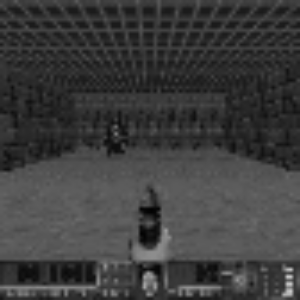

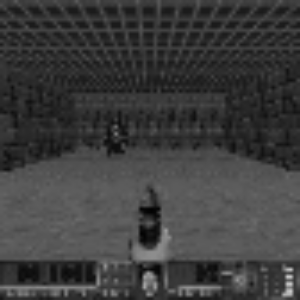

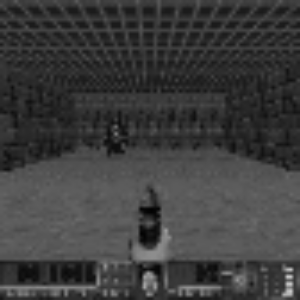

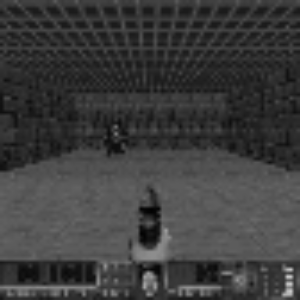

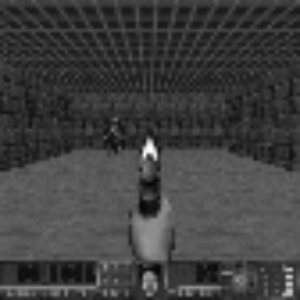

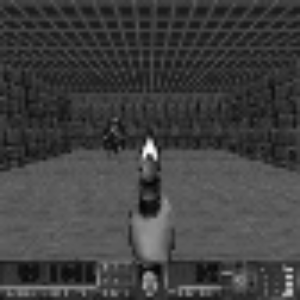

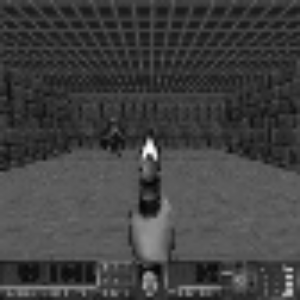

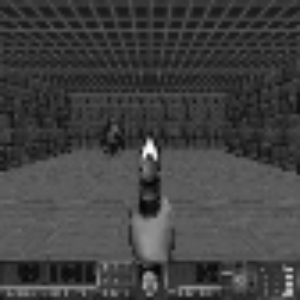

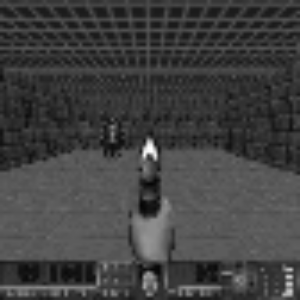

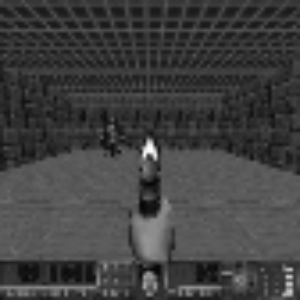

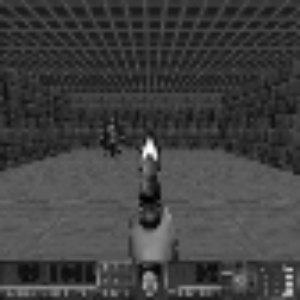

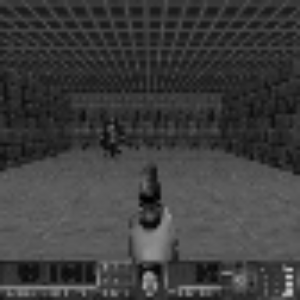

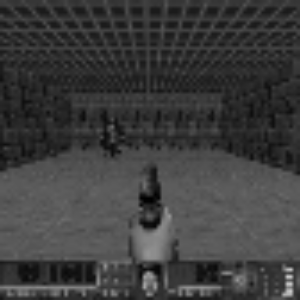

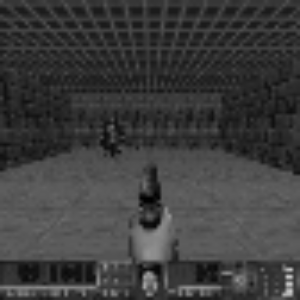

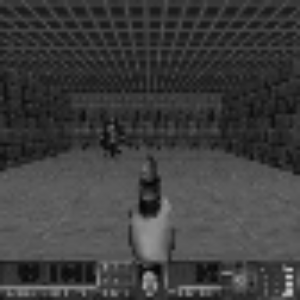

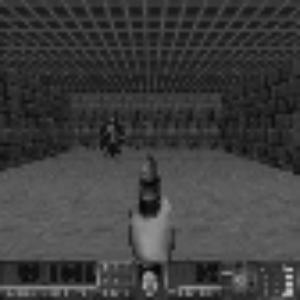

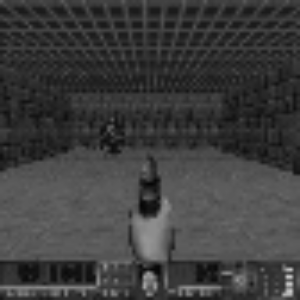

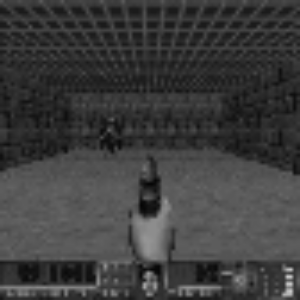

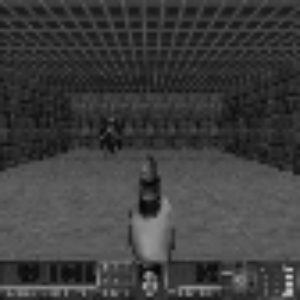

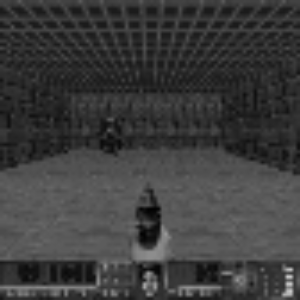

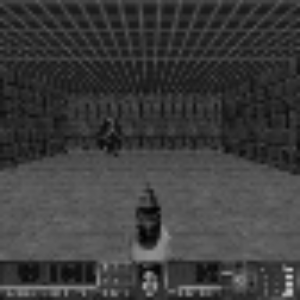

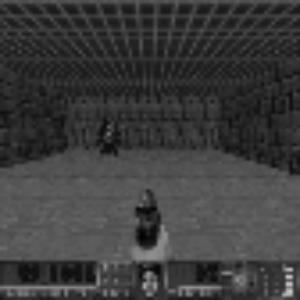

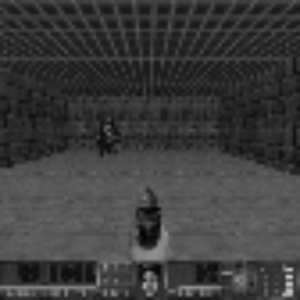

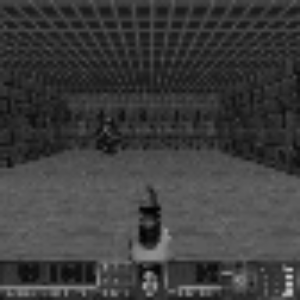

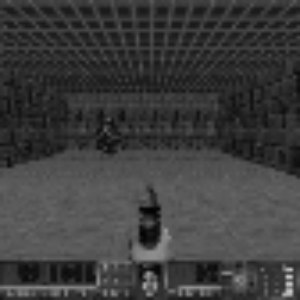

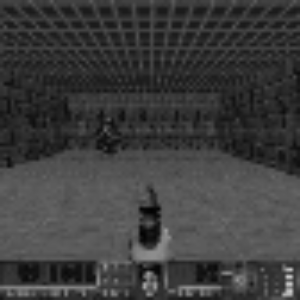

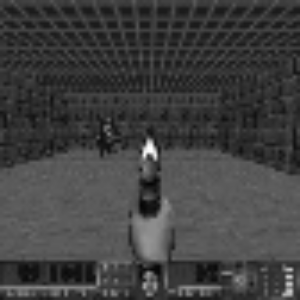

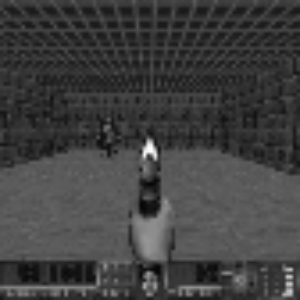

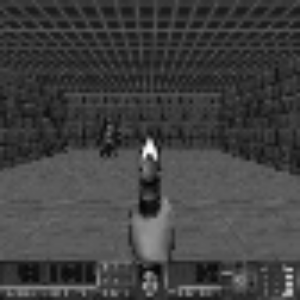

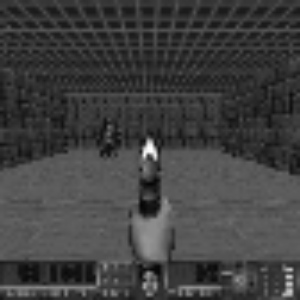

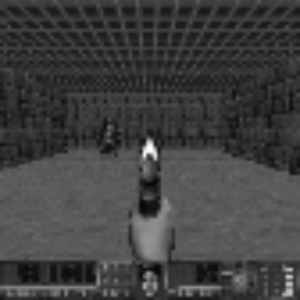

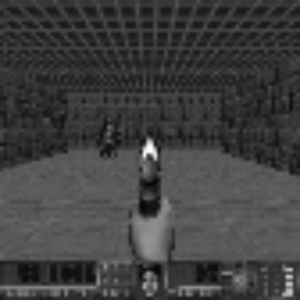

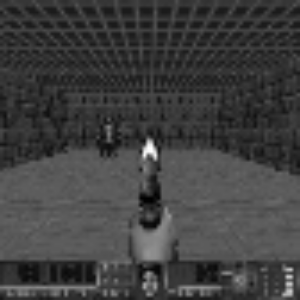

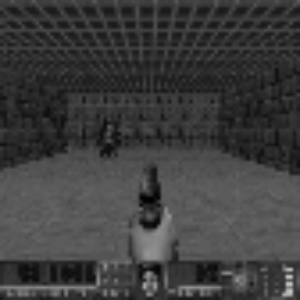

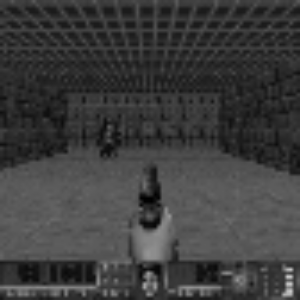

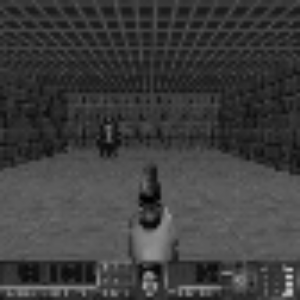

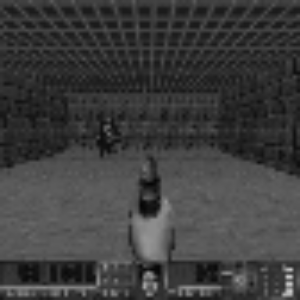

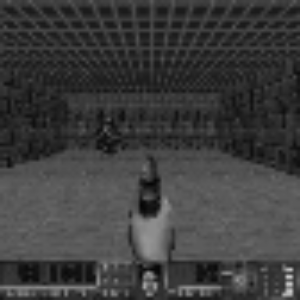

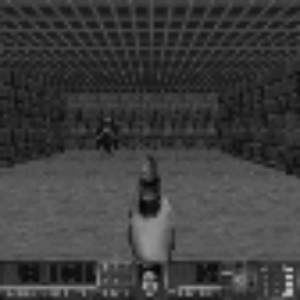

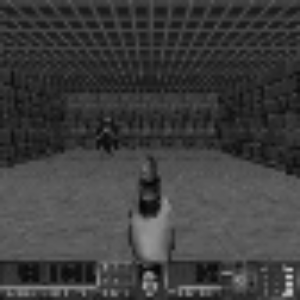

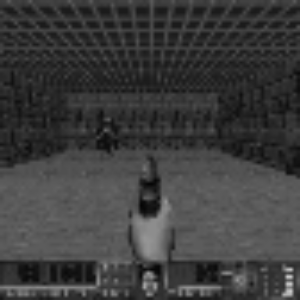

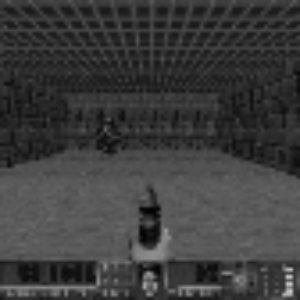

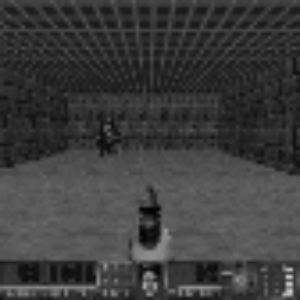

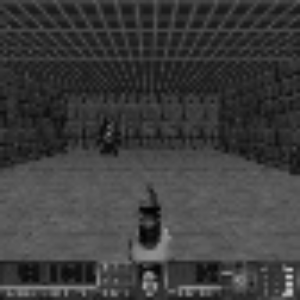

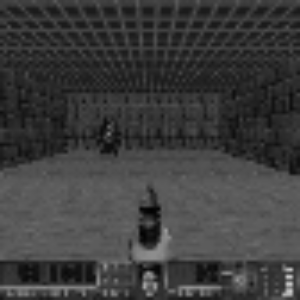

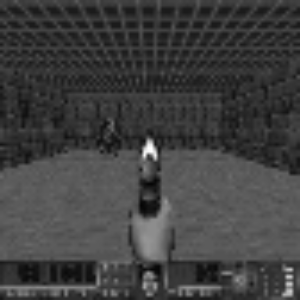

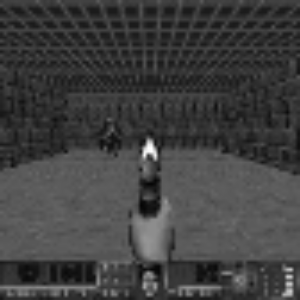

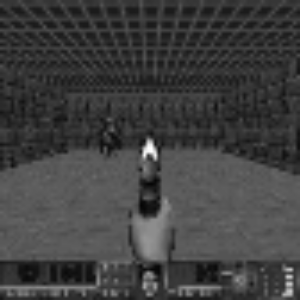

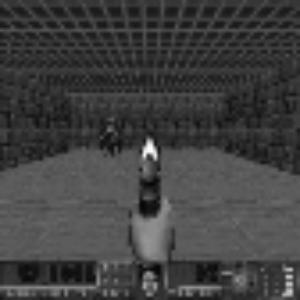

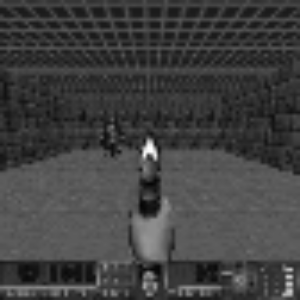

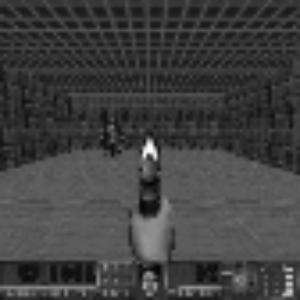

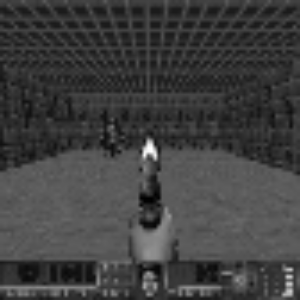

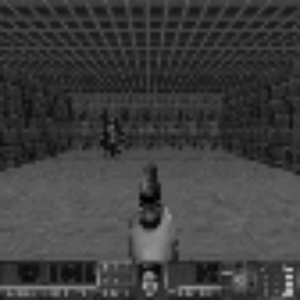

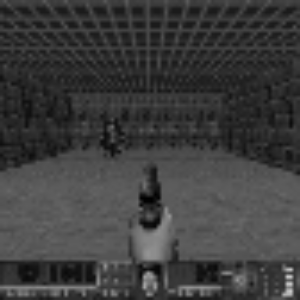

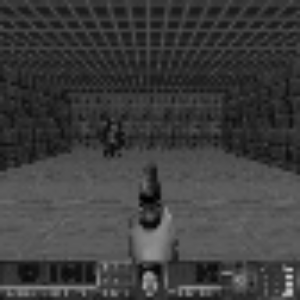

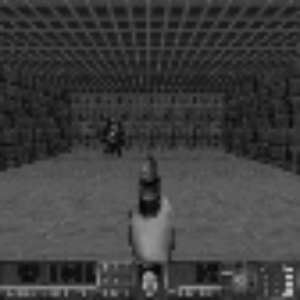

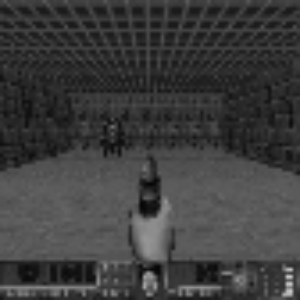

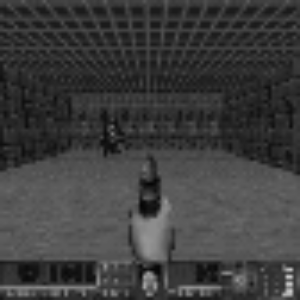

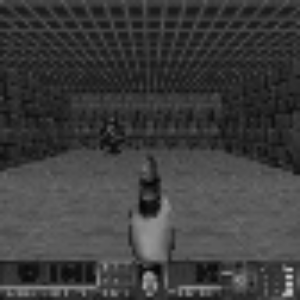

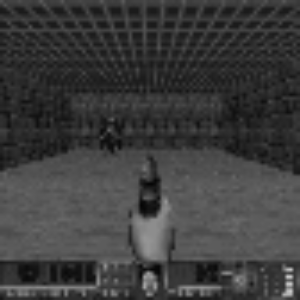

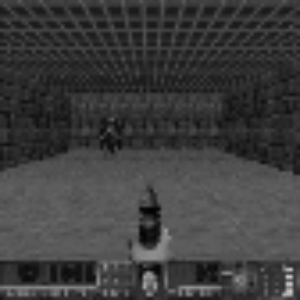

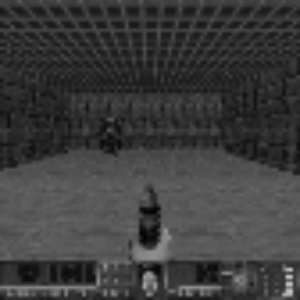

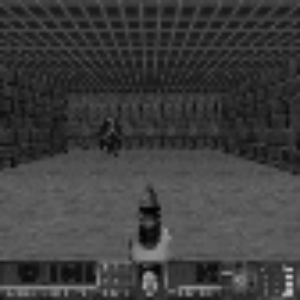

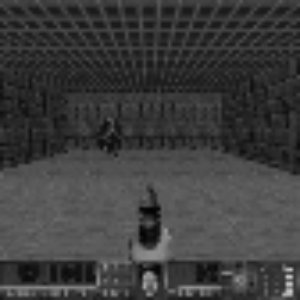

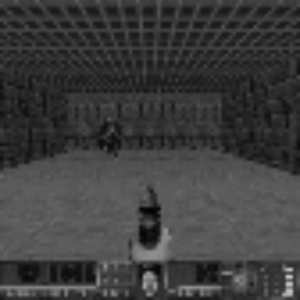

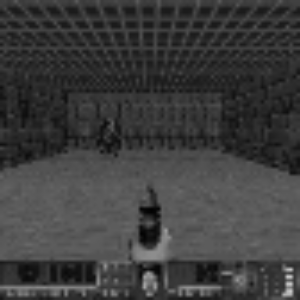

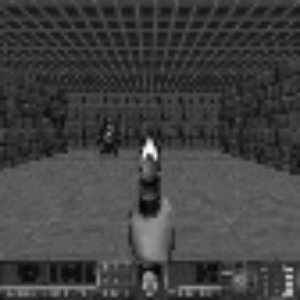

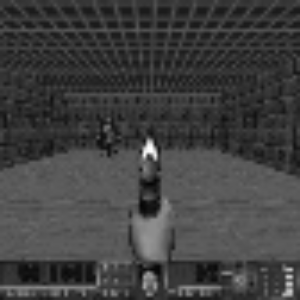

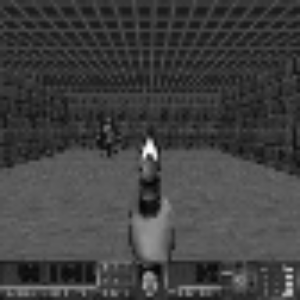

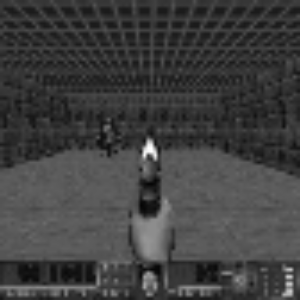

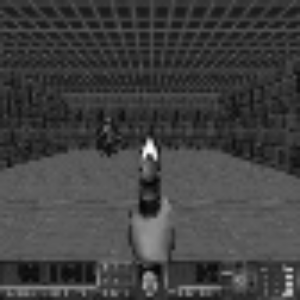

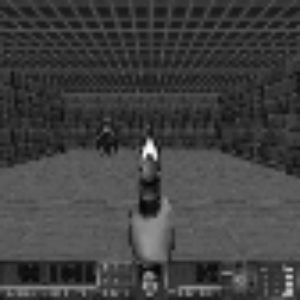

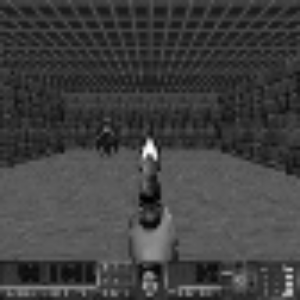

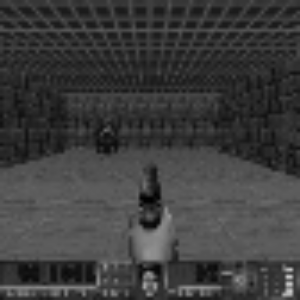

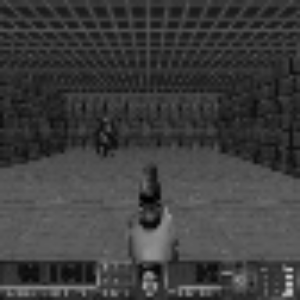

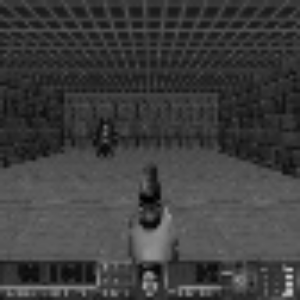

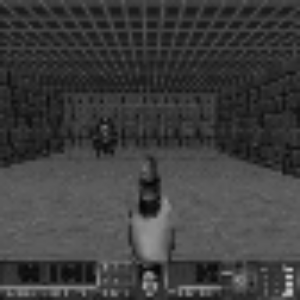

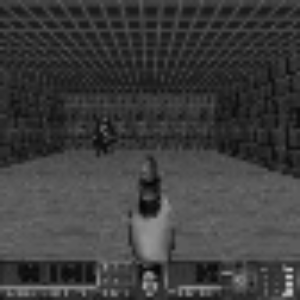

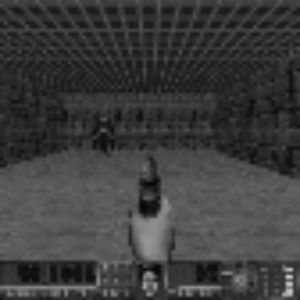

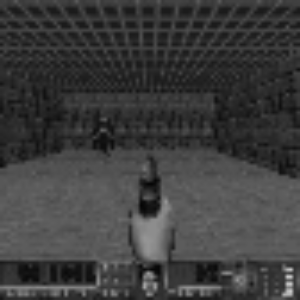

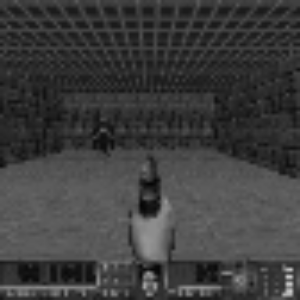

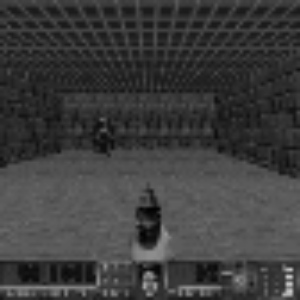

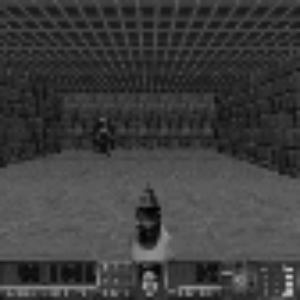

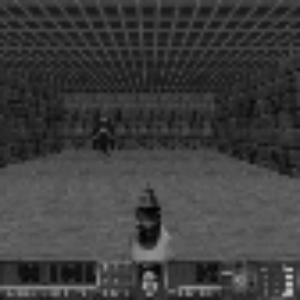

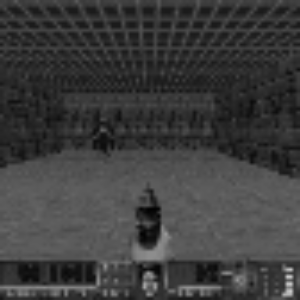

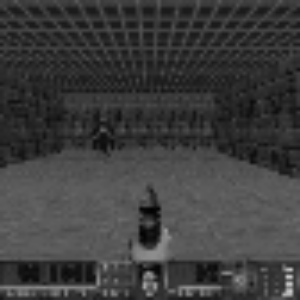

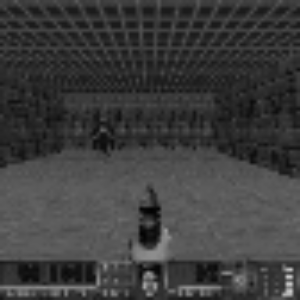

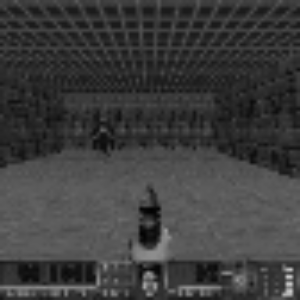

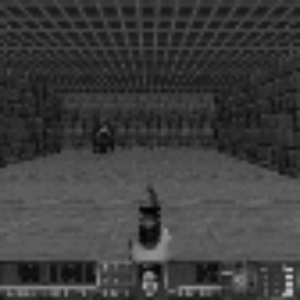

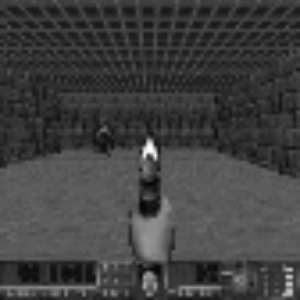

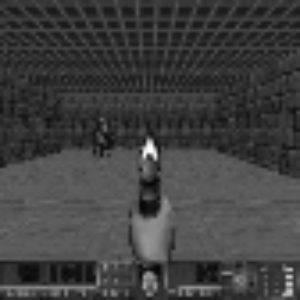

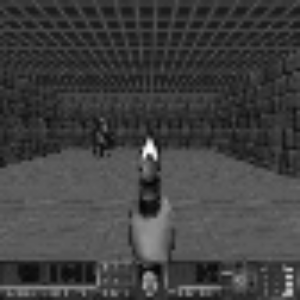

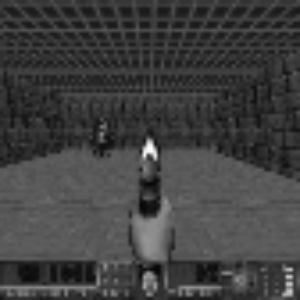

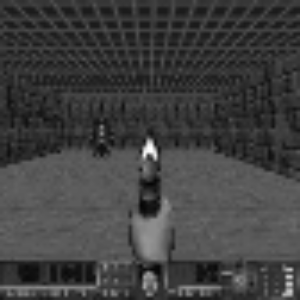

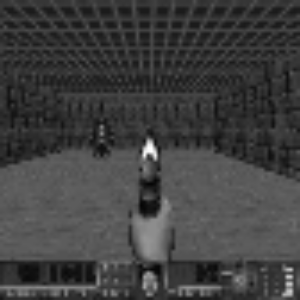

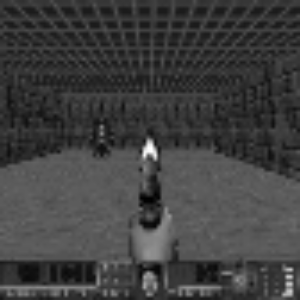

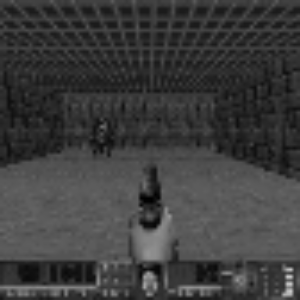

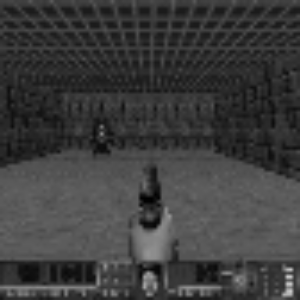

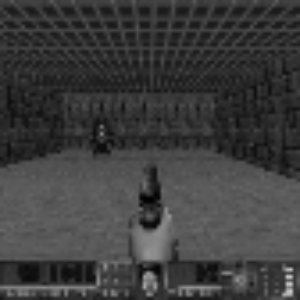

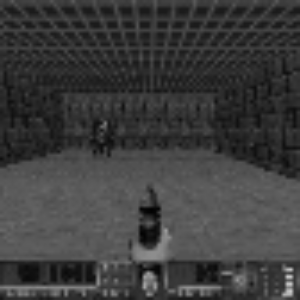

In [12]:
from google.colab.patches import cv2_imshow

obs, _ = env.reset()
for _ in range(100):
    action = env.action_space.sample()
    obs, reward, done, trunc, info = env.step(action)

    frame = obs.squeeze()
    frame = cv2.resize(frame, (300, 300))

    cv2_imshow(frame)  # <-- Colab uyumlu
    if done:
        obs, _ = env.reset()
